In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
%matplotlib inline

### Abstract class containing methods for implementing bandits

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

### ε-Greedy implementation

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.counts_of_arms = np.zeros(narms)#k=narms+1
        self.Qvalues = np.full((narms,),Q0)#use infinity
    

    #This should return an arm integer in {1, . . . , self.narms}
    def play(self, tround, context=None):
        if np.random.random() > self.epsilon:#flipping a coin and chosing an arm at random
            return np.random.choice([i+1 for i, j in enumerate(self.Qvalues) if j == max(self.Qvalues)])
                   #Return the index(arm number) of the arm with the largest Q-value;in case of ties(more than 1 max value) pick a random index
        else:
            return 1+np.random.choice(range(len(self.Qvalues)))#chosing an arm based on calulated Qvalues

    """
    1.Increment the counts field that records the number of times we’ve played each of the arms.
    2.Find the current estimated value of the chosen arm.
      a)If this is our first experience with the chosen arm, we set the estimated value directly.
      b)If we had played the arm in the past, we update the estimated value of the chosen arm to be a weighted average of the
        previously estimated value and the reward we just received
    """
    def update(self, arm, reward, context=None):
        self.counts_of_arms[arm-1] += 1
        n = self.counts_of_arms[arm-1]
        if self.Qvalues[arm-1]==np.inf:#First experience with the arm.
            value=0                    #Done to avoid the issue with Nans'
        else:
            value = self.Qvalues[arm-1]#fetching the previous value of the arm 
        new_value = value * ((n - 1) / float(n)) + reward / float(n)
        self.Qvalues[arm-1] = new_value

#Epsilon-greedy is gullible when it is presented with arms with good rewards.

### UCB implementation

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    

    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.counts_of_arms = [0 for i in range(1,self.narms+1)]
        self.Qvalues = [Q0 for i in range(1,self.narms+1)]#use infinity
        self.Q0 = Q0
        self.rho=rho
        
    def play(self, tround, context=None):#No arm is played randomly
        for arm in range(1,self.narms+1):
            if self.counts_of_arms[arm-1] == 0:
                return arm
        ucbvalues = [0.0 for arm in range(1,self.narms+1)]
        total_counts = sum(self.counts_of_arms)
        for arm in range(1,self.narms+1):
            optimum_factor = np.math.sqrt((self.rho * np.math.log(total_counts)) / float(self.counts_of_arms[arm-1]))
            ucbvalues[arm-1] = self.Qvalues[arm-1] + optimum_factor
        return 1+np.random.choice(np.argwhere(self.Qvalues == np.amax(self.Qvalues)).flatten().tolist())
        #Return the index(arm number) of the arm with the largest Q-value;in case of ties(more than 1 max value) pick a random index
    """
    1.Increment the counts field that records the number of times we’ve played each of the arms.
    2.Find the current estimated value of the chosen arm.
      a)If this is our first experience with the chosen arm, we set the estimated value directly.
      b)If we had played the arm in the past, we update the estimated value of the chosen arm to be a weighted average of the
        previously estimated value and the reward we just received
    """
    def update(self, arm, reward, context=None):
        self.counts_of_arms[arm-1] += 1
        n = self.counts_of_arms[arm-1]
        if self.Qvalues[arm-1]==np.inf:#This is done to avoid Nan issue.
            value=0
        else:
            value = self.Qvalues[arm-1]#fetching the previous value of the arm 
        new_value = value * ((n - 1) / float(n)) + reward / float(n)# Recompute the estimated value of chosen arm using new reward
        self.Qvalues[arm-1] = new_value
    """
    UCB is not gullible unlike Epsilon greedy, rather it is optimistic for those arms for which the count is less.
    UCB thinks that the arms with less counts have not been 'explored' enough;this scenario occurs because 
    math.log(total_counts))/ float(self.counts[arm]) becomes large for arms that we know little about. 
    That means we try hard to learn about arms if we don’t know enough about them, even if they seem a little worse than the best arm.
    """



### LinUCB with disjoint linear models  implementation
http://rob.schapire.net/papers/www10.pdf

In [12]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    ========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context i.e length of context vector for each arm  

    alpha : float
        positive real explore-exploit parameter i.e. exploitation rate
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = float(alpha)
        self.theta = np.zeros((self.ndims,self.ndims,1))#An array of vectors to maintain coefficient estimates
        self.A = np.array([np.identity(self.ndims) for col in range(1, narms + 1)])#An array of length 10 of (10,10)identity matrices for each arm
        self.b = np.zeros((self.ndims,self.ndims,1))#An array of length 10 of (10,1)vectors
        
    def play(self, tround, context):
        posterior = [0 for col in range(1, self.narms + 1)]
        context_matrix = context.reshape((self.ndims, self.ndims))
        for arm in range(1, self.narms + 1):
            self.theta[arm - 1] = np.dot(inv(self.A[arm - 1]), self.b[arm - 1])# Updating coefficient vector for an arm
            X = context_matrix[arm - 1].reshape((self.ndims, 1))# Calculating X for each arm which is (10x1) vector
            stdev = np.math.sqrt(np.dot(np.dot(X.T , inv(self.A[arm - 1])) , X))#standard deviation
            posterior[arm - 1] = (np.dot(self.theta[arm - 1].T ,X)) + self.alpha * stdev#updating posterior(our belief about an arm) which was initialized to zero
        return np.random.choice([i for i, j in enumerate(posterior) if j == max(posterior)]) + 1#chosing an arm at random and breaking the ties if they occur

    def update(self, arm, reward, context):
        context_matrix = context.reshape((self.ndims, self.ndims))#Reshaping the context of an event to ten(10,1) contexts, one for each arm.
        X=context_matrix[arm-1].reshape(self.ndims,1)#reshaping the context from (10,) to (10,1)
        self.A[arm-1] += np.dot(X,X.T)
        self.b[arm-1]+=reward * X
      
        

### Evaluation 

In [8]:
def evaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    nevents=len(arms)
    history=[]#To maintain the history of events,as specified in the algorithm
    rewardsTobeReturned=[]
    tround=1
    event=0
    DEBUG=False#set this to true to print values
    while tround<=nrounds:
        while event<nevents:#This loop ensures that the execution resumes from the next event in the log when the execution had to break out in the previous execution
            arm_from_log = arms[event]
            reward_from_log = rewards[event]
            record = data[event]#to maintain history as mentioned in the algorithm
            context = contexts[event]
            arm_selected_by_algorithm = mab.play(len(history)+1,context)
            event+=1
            if float(arm_selected_by_algorithm) == float(arm_from_log):#If the arm selected by the bandit algorithm matches in the log then we update our knowledge about that arm.
                mab.update(arm_selected_by_algorithm ,reward_from_log,context)
                rewardsTobeReturned.append(reward_from_log)#this is returned in the end
                history.append(record)
                break
        tround+=1#updating the rounds. i.e. 1,2,..800
    if DEBUG:
        print(len(rewardsTobeReturned))
        print("tround",tround)
        print("event",event)
    return rewardsTobeReturned

In [ ]:
#Reading the dataset
data = np.loadtxt("/home/nizam/Desktop/Sem2//M.L./project2/data")
arms=data[:,0]
rewards=data[:,1]
contexts=data[:,2:]

In [13]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = evaluate(mab, arms, rewards, contexts,800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.25125


In [15]:
mab = UCB(10, 1.0)
results_UCB = evaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.195


In [17]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = evaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


Text(0.5,1,'Plot of per-round cumulative reward as a function of round')

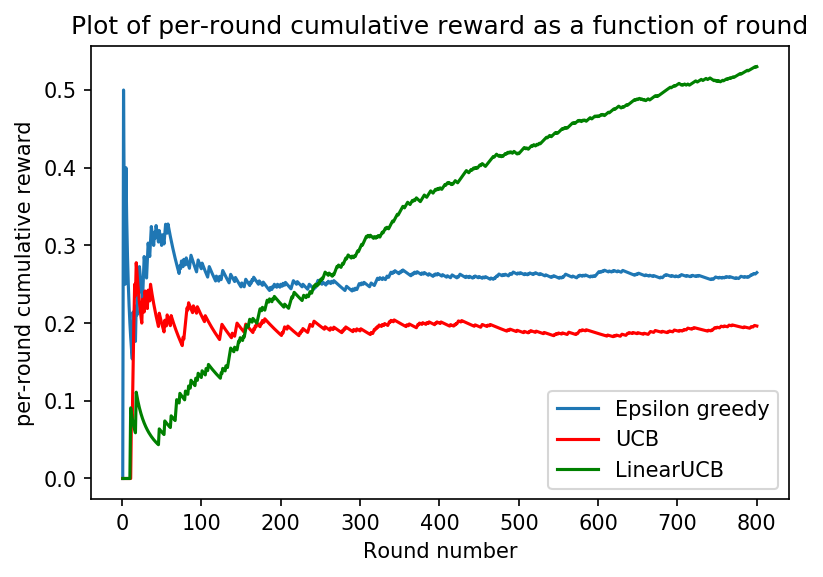

In [75]:
plt.subplots(dpi=150)
plt.plot(np.arange(1,801),np.cumsum(results_EpsGreedy)/np.arange(1,801),label='Epsilon greedy')
plt.plot(np.arange(1,801),np.cumsum(results_UCB)/np.arange(1,801),'r',label='UCB')
plt.plot(np.arange(1,801),np.cumsum(results_LinUCB)/np.arange(1,801),'g',label='LinearUCB')
plt.legend()
plt.xlabel('Round number')
plt.ylabel('per-round cumulative reward')
plt.title('Plot of per-round cumulative reward as a function of round')

### grid search 

No handles with labels found to put in legend.


Text(0.5,1,'A grid-search based strategy to select the hyperparameter in LinUCB')

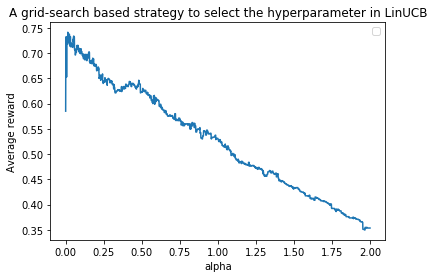

In [78]:
avgReward=[]
alphas=[]
for i in np.arange(0,2,0.001):
    mab = LinUCB(10, 10, i)
    results_LinUCB = evaluate(mab, arms, rewards, contexts, 800)
    avgReward.append(np.mean(results_LinUCB))
    alphas.append(i)
plt.plot(alphas,avgReward)
plt.legend()
plt.xlabel('alpha')
plt.ylabel('Average reward')
plt.title('A grid-search based strategy to select the hyperparameter in LinUCB')

In [79]:
alpha =[alphas[i] for i, j in enumerate(avgReward) if j == max(avgReward)][0]
print("The maximum average reward is at",alpha)

The maximum average reward is at 0.014
